### Put uncompressed data in a CSV

In [74]:
import numpy as np
import xarray as xr
import pandas as pd

# Step 1: Function to parse .hdr file metadata with adjusted split logic
def parse_hdr_file(hdr_path):
    with open(hdr_path, 'r') as hdr_file:
        hdr_lines = hdr_file.readlines()
    
    metadata = {}
    for line in hdr_lines:
        if '=' in line:
            key, value = line.split('=', 1)
            metadata[key.strip()] = value.strip()
    
    samples = int(metadata['samples'])
    lines = int(metadata['lines'])
    bands = int(metadata['bands'])
    dtype_map = {'4': np.float32, '12': np.int16, '5': np.float64}  # Updated to include float64
    dtype = dtype_map[metadata['data type']]
    
    return samples, lines, bands, dtype

# Step 2: Load binary data as xarray DataArray
def load_binary_as_xarray(bin_path, samples, lines, bands, dtype):
    data = np.fromfile(bin_path, dtype=dtype).reshape((lines, samples, bands))
    data_array = xr.DataArray(data, dims=("lines", "samples", "band"))
    return data_array

# Step 3: Generate bit information for each band
def compute_bit_information(data_array, dtype):
    # Determine the number of bits based on the data type
    if dtype == np.float32:
        num_bits = 32
    elif dtype == np.float64:
        num_bits = 64
    else:
        raise ValueError("Unsupported data type for bit analysis.")
    
    # Simulating bit information for each band
    num_bands = data_array.sizes["band"]
    bit_info = xr.DataArray(
        np.random.rand(num_bands, num_bits),  # Simulating bit information for each band
        dims=["band", f"bit{num_bits}"]
    )
    return bit_info

# Step 4: Structure bit information for CSV output
def compute_and_structure_bit_information(data_array, dtype):
    bit_info = compute_bit_information(data_array, dtype)

    # Determine number of bits for verification
    num_bits = 32 if dtype == np.float32 else 64 if dtype == np.float64 else None
    if num_bits is None:
        raise ValueError("Unsupported data type for bit analysis.")

    # Check dimensions to confirm alignment
    if "band" not in bit_info.dims:
        raise ValueError("Expected 'band' dimension in bit_info")
    if bit_info.sizes[f"bit{num_bits}"] != num_bits:
        raise ValueError(f"Expected {num_bits} bits in 'bit{num_bits}' dimension of bit_info")

    # Structure the bit information by bands for CSV
    bit_info_rows = []
    for band in range(data_array.sizes["band"]):
        bit_data = bit_info.sel(band=band).values  # Correctly select based on band
        if len(bit_data) != num_bits:
            raise ValueError(f"Unexpected bit_data length for band {band}: {len(bit_data)}")

        # Construct a row for each band
        bit_info_rows.append({
            "band": band,
            **{f"bit{i+1}": bit_data[i] for i in range(num_bits)}
        })

    bit_info_df = pd.DataFrame(bit_info_rows)
    return bit_info_df

# Step 5: Save the bit information to CSV
def save_bit_information_to_csv(bit_info_df, filename):
    bit_info_df.to_csv(filename, index=False)

# Step 6: Running the process
hdr_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT.hdr"
bin_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT"

# Load metadata
samples, lines, bands, dtype = parse_hdr_file(hdr_path)

# Load data as xarray DataArray
data_array = load_binary_as_xarray(bin_path, samples, lines, bands, dtype)

# Compute and structure bit information
bit_info_df = compute_and_structure_bit_information(data_array, dtype)

# Save to CSV
save_bit_information_to_csv(bit_info_df, "bit_information_by_band.csv")


### Visualize bits of uncompressed data

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4y/vdf6lk8d18qf_nvdqb40_nfw0000gn/T/ipykernel_22598/2377013395.py:16: SyntaxWarning: invalid escape sequence '\d'
  bit_info_long["bit"] = bit_info_long["bit"].str.extract('(\d+)').astype(int)


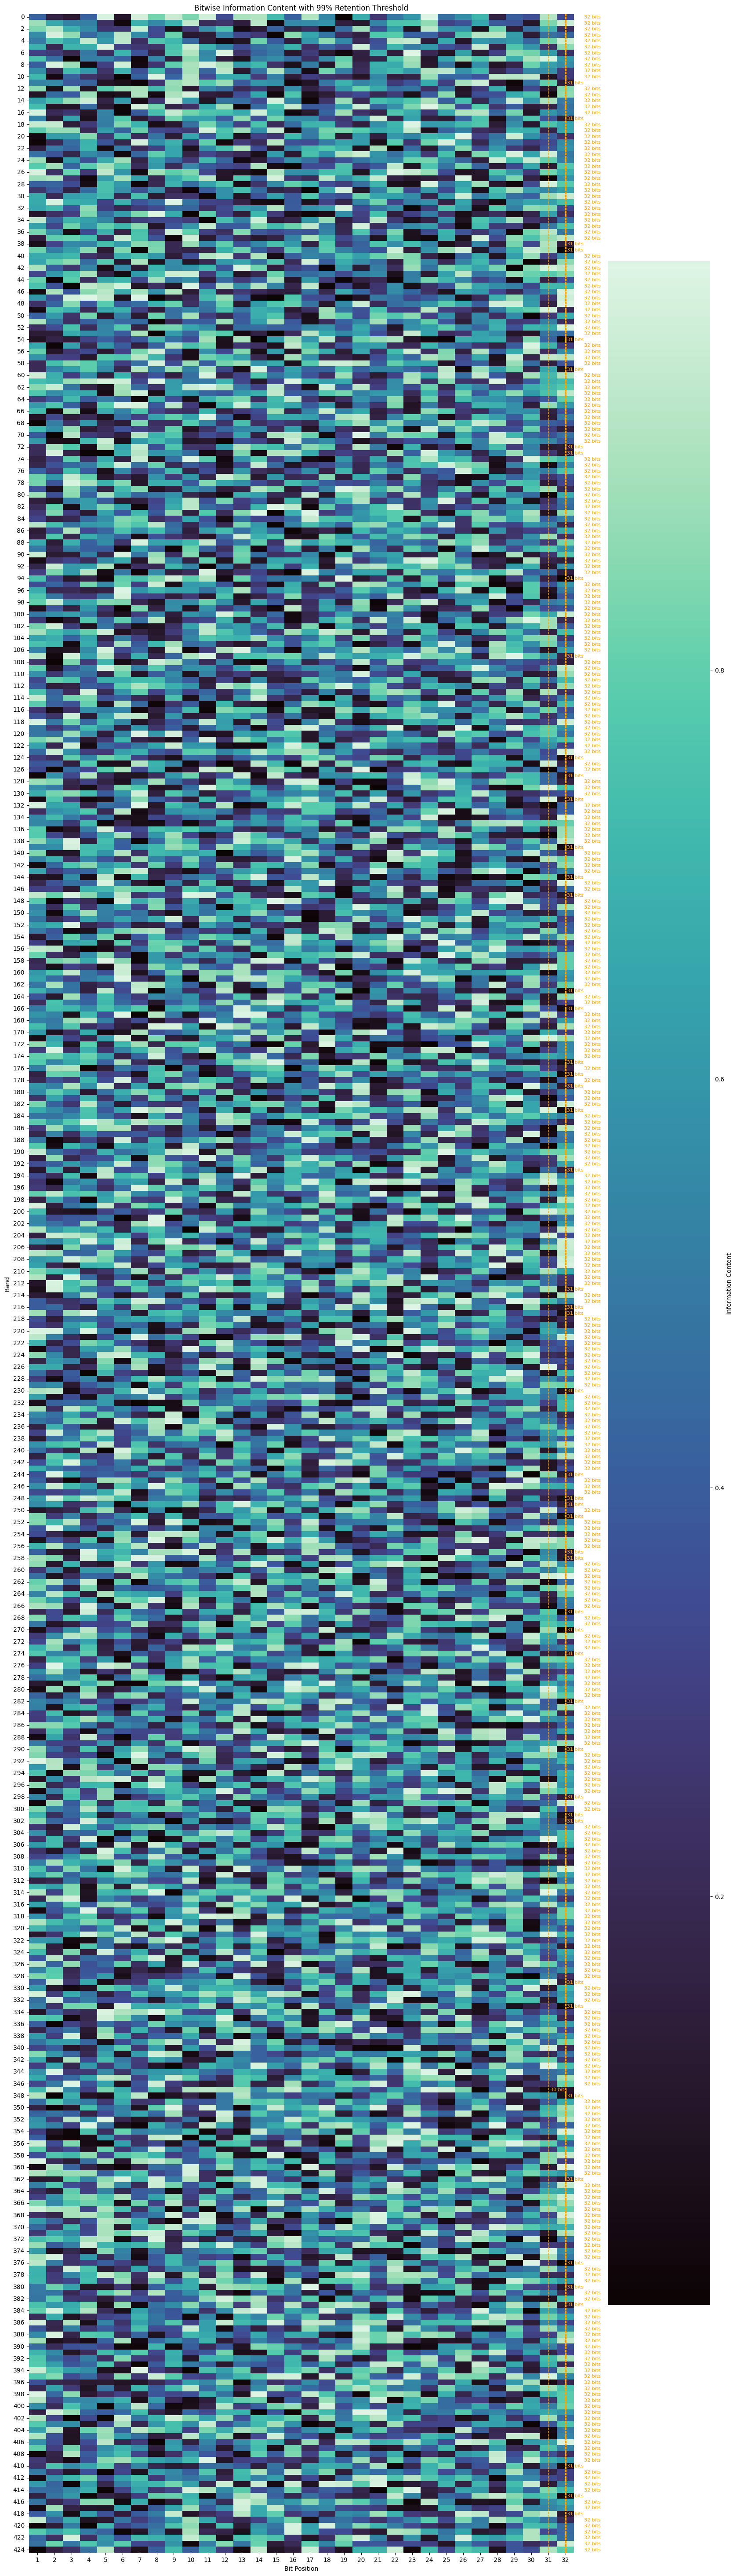

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load CSV data
csv_path = "/Users/kitlewers/Desktop/naive_compression/code/bit_information_by_band.csv"  # replace with actual path
bit_info_df = pd.read_csv(csv_path)

# Step 2: Prepare data for plotting
# Melt the dataframe to have 'band' and 'bit' columns
bit_info_long = bit_info_df.melt(id_vars=["band"], 
                                 var_name="bit", 
                                 value_name="information_content")

# Convert bit columns to integers (e.g., 'bit1' -> 1, 'bit2' -> 2, etc.)
bit_info_long["bit"] = bit_info_long["bit"].str.extract('(\d+)').astype(int)

# Step 3: Calculate cumulative information for each band to find 99% cutoff
bit_info_long = bit_info_long.sort_values(["band", "bit"])  # Ensure data is sorted
bit_info_long["cumulative_info"] = bit_info_long.groupby("band")["information_content"].cumsum()
bit_info_long["total_info"] = bit_info_long.groupby("band")["information_content"].transform("sum")
bit_info_long["percent_info"] = bit_info_long["cumulative_info"] / bit_info_long["total_info"]

# Find the bit position where cumulative information content first exceeds 99%
threshold_data = bit_info_long[bit_info_long["percent_info"] >= 0.99].drop_duplicates("band")
threshold_data = threshold_data.set_index("band")["bit"]

# Step 4: Pivot data for heatmap plotting
heatmap_data = bit_info_long.pivot(index="band", columns="bit", values="information_content")

# Step 5: Custom colormap and plot the heatmap
cmap = sns.color_palette("mako", as_cmap=True)
plt.figure(figsize=(20, 75))
sns.heatmap(heatmap_data, cmap=cmap, cbar_kws={'label': 'Information Content'})

# Step 6: Overlay the 99% information threshold as vertical lines for each band
for band, bit_cutoff in threshold_data.items():
    plt.axvline(bit_cutoff + 0.5, color='orange', linestyle="--", linewidth=1)  # Vertical line at the threshold bit
    plt.text(bit_cutoff + 0.6, band + 0.5, f"{bit_cutoff} bits", color="orange", ha="left", va="center", fontsize=8)

# Customize the plot to resemble the original paper's style
plt.xlabel("Bit Position")
plt.ylabel("Band")
plt.title("Bitwise Information Content with 99% Retention Threshold")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


### X-Bit Info Compression

In [83]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xbitinfo import get_bitinformation

# Step 1: Load Hyperspectral Data
def parse_hdr_file(hdr_path):
    with open(hdr_path, 'r') as hdr_file:
        hdr_lines = hdr_file.readlines()

    metadata = {}
    for line in hdr_lines:
        if '=' in line:
            key, value = line.split('=', 1)
            metadata[key.strip()] = value.strip()

    samples = int(metadata['samples'])
    lines = int(metadata['lines'])
    bands = int(metadata['bands'])
    dtype_map = {'4': np.float32, '12': np.int16, '5': np.float64}
    dtype = dtype_map[metadata['data type']]

    return samples, lines, bands, dtype

def load_binary_as_xarray(bin_path, samples, lines, bands, dtype):
    data = np.fromfile(bin_path, dtype=dtype).reshape((lines, samples, bands))
    data_array = xr.DataArray(data, dims=("lines", "samples", "band"))
    return data_array

# Step 2: Analyze Hyperspectral Data
hdr_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT.hdr"
bin_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT"

# Load metadata
samples, lines, bands, dtype = parse_hdr_file(hdr_path)

# Load data as xarray DataArray
data_array = load_binary_as_xarray(bin_path, samples, lines, bands, dtype)

# Convert DataArray to Dataset
data_ds = data_array.to_dataset(name="hyperspectral_data")

# Calculate bitwise information content per band using xbitinfo
info_per_bit = get_bitinformation(data_ds, dim="band")

# Determine the bit dimension name based on dtype
bitdim = "bit32" if dtype == np.float32 else "bit64"

# Step 3: Extract Bit Information and Save to CSV
# Prepare to extract information content for each band
bit_info_df_list = []

# Iterate over each bit
for bit in range(info_per_bit.sizes[bitdim]):
    # Extract information for each bit and transpose to get bands as rows
    bit_info = info_per_bit.isel({bitdim: bit})
    bit_info_values = bit_info["hyperspectral_data"].values  # Assuming 'hyperspectral_data' is the variable name
    bit_info_df = pd.DataFrame({
        "band": np.arange(bands),
        f"bit{bit + 1}": bit_info_values
    })
    bit_info_df_list.append(bit_info_df)

# Combine bit information into a single DataFrame
final_bit_info_df = pd.concat(bit_info_df_list, axis=1).loc[:, ~pd.concat(bit_info_df_list, axis=1).columns.duplicated()]

# Save to CSV
csv_output_path = "/Users/kitlewers/Desktop/naive_compression/code/compressed_bit_information_by_band.csv"
final_bit_info_df.to_csv(csv_output_path, index=False)

print(f"Bitwise information content saved to {csv_output_path}")


Processing hyperspectral_data:   0%|          | 0/1 [00:00<?, ?it/s]DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
Processing hyperspectral_data: 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None


Bitwise information content saved to /Users/kitlewers/Desktop/naive_compression/code/compressed_bit_information_by_band.csv


### XBit Info Compression Putting into a csv

In [89]:
import numpy as np
import xarray as xr
import pandas as pd
from xbitinfo import get_bitinformation

# Step 1: Load Hyperspectral Data
def parse_hdr_file(hdr_path):
    with open(hdr_path, 'r') as hdr_file:
        hdr_lines = hdr_file.readlines()

    metadata = {}
    for line in hdr_lines:
        if '=' in line:
            key, value = line.split('=', 1)
            metadata[key.strip()] = value.strip()

    samples = int(metadata['samples'])
    lines = int(metadata['lines'])
    bands = int(metadata['bands'])
    dtype_map = {'4': np.float32, '12': np.int16, '5': np.float64}
    dtype = dtype_map[metadata['data type']]

    return samples, lines, bands, dtype

def load_binary_as_xarray(bin_path, samples, lines, bands, dtype):
    data = np.fromfile(bin_path, dtype=dtype).reshape((lines, samples, bands))
    data_array = xr.DataArray(data, dims=("lines", "samples", "band"))
    return data_array

# Step 2: Analyze Hyperspectral Data
hdr_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT.hdr"
bin_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT"

# Load metadata
samples, lines, bands, dtype = parse_hdr_file(hdr_path)

# Load data as xarray DataArray
data_array = load_binary_as_xarray(bin_path, samples, lines, bands, dtype)

# Prepare to extract bitwise information content for each band
bit_info_df_list = []

# Step 3: Calculate Bit Information Independently for Each Band
for band in range(bands):
    # Extract the current band as a new DataArray
    band_data = data_array.sel(band=band)
    
    # Convert to Dataset to be used with get_bitinformation
    band_ds = band_data.to_dataset(name="hyperspectral_data")

    # Calculate bitwise information content for the current band
    info_per_bit = get_bitinformation(band_ds, dim="lines")  # Assuming "lines" is the dimension for bitwise analysis

    # Determine the bit dimension name based on dtype
    bitdim = [dim for dim in info_per_bit.dims if 'bit' in dim][0]

    # Extract bit information for each bit
    bit_info_values = {}
    for bit in range(info_per_bit.sizes[bitdim]):
        # Extract the bit information
        bit_info = info_per_bit.isel({bitdim: bit})
        
        # Check if the value is scalar (0-dimensional) or an array and handle appropriately
        if bit_info["hyperspectral_data"].ndim == 0:
            bit_info_values[f"bit{bit + 1}"] = bit_info["hyperspectral_data"].item()
        else:
            bit_info_values[f"bit{bit + 1}"] = bit_info["hyperspectral_data"].values[0]

    # Append the band information as a new DataFrame row
    bit_info_df = pd.DataFrame(bit_info_values, index=[band])
    bit_info_df["band"] = band
    bit_info_df_list.append(bit_info_df)

# Step 4: Combine Results into a Single DataFrame
final_bit_info_df = pd.concat(bit_info_df_list, ignore_index=True)

# Step 5: Save to CSV
csv_output_path = "/Users/kitlewers/Desktop/naive_compression/code/compressed_bit_information_by_band.csv"
final_bit_info_df.to_csv(csv_output_path, index=False)

print(f"Bitwise information content saved to {csv_output_path}")


Processing hyperspectral_data:   0%|          | 0/1 [00:00<?, ?it/s]DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
Processing hyperspectral_data: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
Processing hyperspectral_data:   0%|          | 0/1 [00:00<?, ?it/s]DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
Processing hyperspectral_data: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None
Processing hyperspectral_data:   0%|          | 0/1 [00:00<?, ?it/s]DEBUG (22598) exception occured? None
DEBUG:julia:

Bitwise information content saved to /Users/kitlewers/Desktop/naive_compression/code/compressed_bit_information_by_band.csv


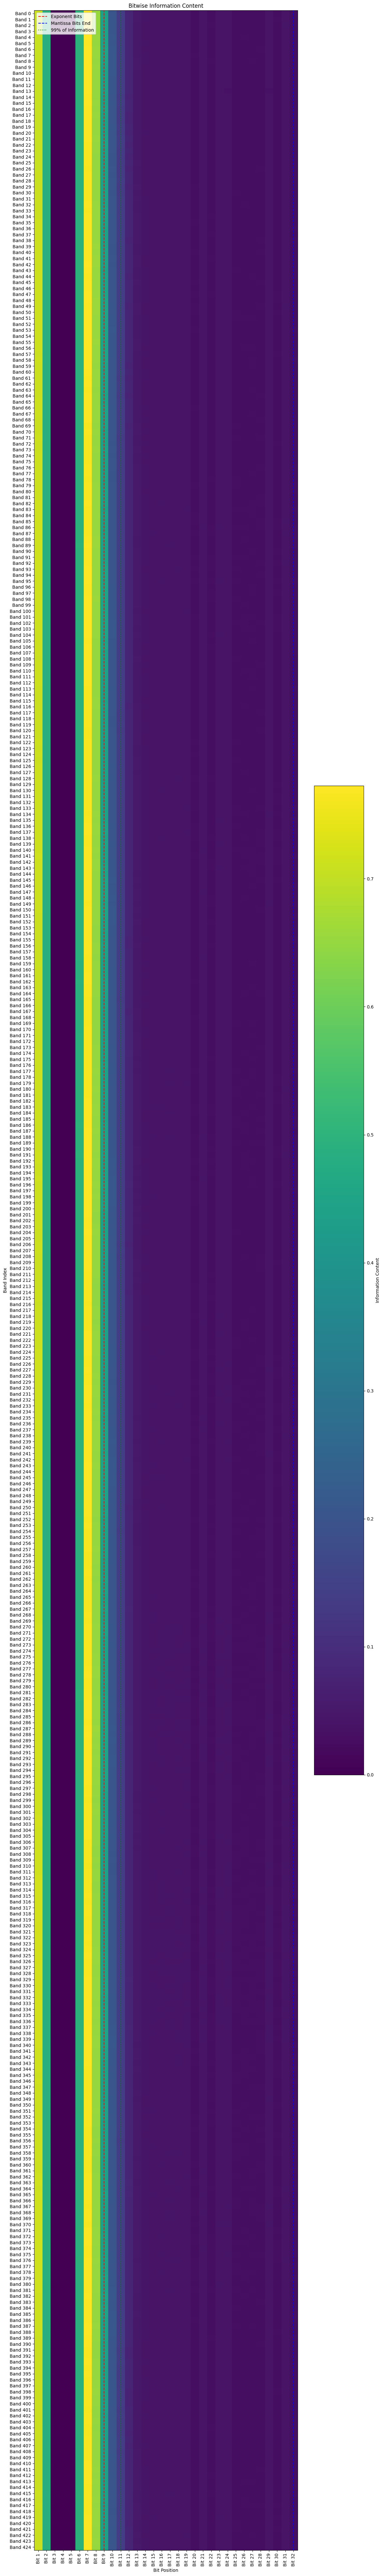

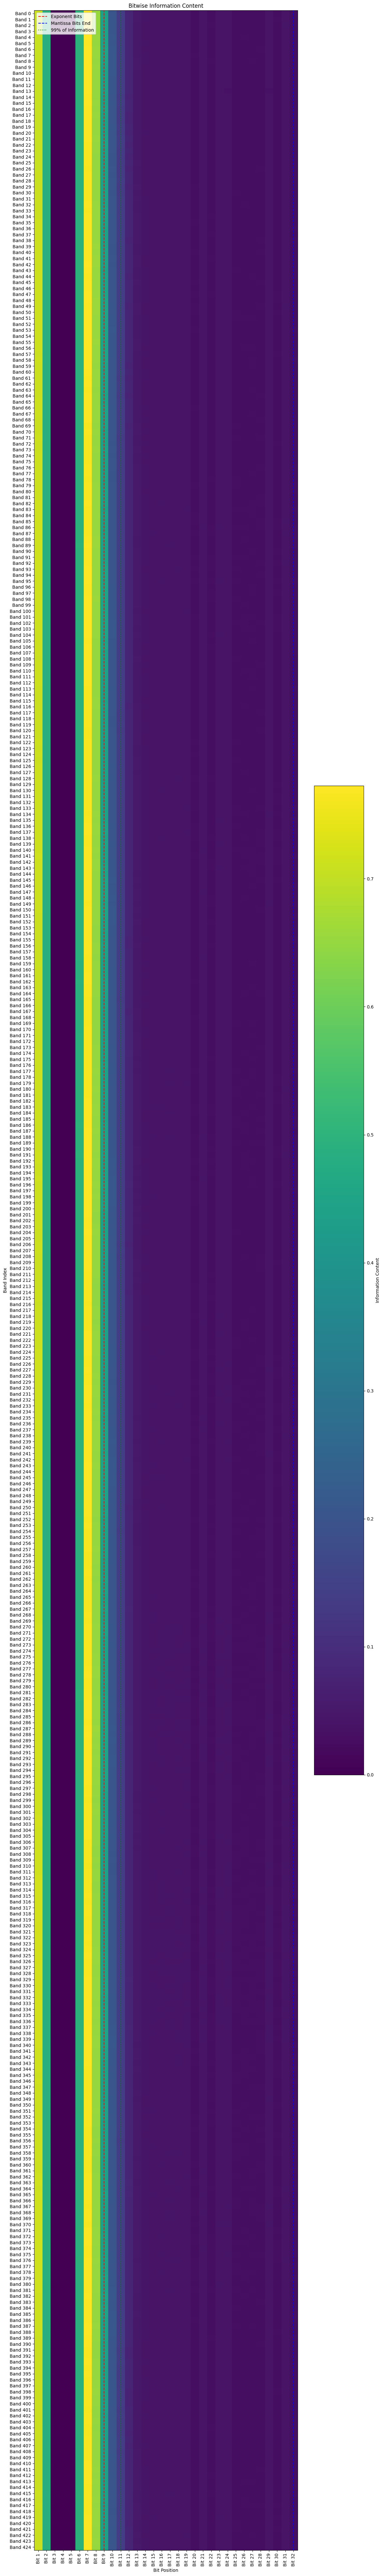

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_bitwise_information(csv_path, cmap="viridis"):
    """
    Plot bitwise information content as in Klöwer et al. 2021 Figure 2.
    """
    # Load the CSV data
    df = pd.read_csv(csv_path)
    bit_columns = [col for col in df.columns if col.startswith('bit')]
    bands = df['band'].values

    # Extract bitwise information values
    bitwise_data = df[bit_columns].values

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 80))
    cax = ax.imshow(bitwise_data, aspect='auto', cmap=cmap, interpolation='nearest')

    # Set axis labels and titles
    ax.set_title('Bitwise Information Content')
    ax.set_xlabel('Bit Position')
    ax.set_ylabel('Band Index')
    ax.set_xticks(np.arange(len(bit_columns)))
    ax.set_xticklabels([f'Bit {i+1}' for i in range(len(bit_columns))], rotation=90)
    ax.set_yticks(np.arange(len(bands)))
    ax.set_yticklabels([f'Band {int(b)}' for b in bands])

    # Add colorbar
    cbar = fig.colorbar(cax, orientation='vertical')
    cbar.set_label('Information Content')

    # Example annotations for mantissa bits and 99% information
    n_exponent_bits = 8  # Typical for 32-bit floating-point
    n_mantissa_bits = 23  # Typical for 32-bit floating-point
    ax.axvline(x=n_exponent_bits, color='red', linestyle='--', label='Exponent Bits')
    ax.axvline(x=n_exponent_bits + n_mantissa_bits, color='blue', linestyle='--', label='Mantissa Bits End')

    # Assuming you have some calculation to determine 99% information
    ax.axvline(x=10, color='green', linestyle=':', label='99% of Information')

    ax.legend()

    plt.tight_layout()
    plt.show()
    return fig

# Example usage:
csv_path = '/Users/kitlewers/Desktop/naive_compression/code/compressed_bit_information_by_band.csv'
plot_bitwise_information(csv_path)
